<a href="https://colab.research.google.com/github/tien2612/Plant-Disease-Website/blob/master/model/apple_leaf_diseases_with_inceptionresnetv2_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# What is this about?
Apples are one of the most important temperate fruit crops in the world. Foliar (leaf) diseases pose a major threat to the overall productivity and quality of apple orchards. The current process for disease diagnosis in apple orchards is based on manual scouting by humans, which is time-consuming and expensive. 

The main objective of the competition is to develop machine learning-based models to accurately classify a given leaf image from the test dataset to a particular disease category, and to identify an individual disease from multiple disease symptoms on a single leaf image. 

# Import the necessary libraries

In [44]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
import PIL
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
from tqdm import tqdm
import tensorflow_addons as tfa
import random
from sklearn.preprocessing import MultiLabelBinarizer

pd.set_option("display.max_columns", None)

**All file path import**

In [45]:
your_path ='Documents/multidiscipline-project'

Let's explore the data.
How many images are in the datset, the labels and their frequencies.

18632
Index(['image', 'labels'], dtype='object')
Axes(0.125,0.11;0.775x0.77)


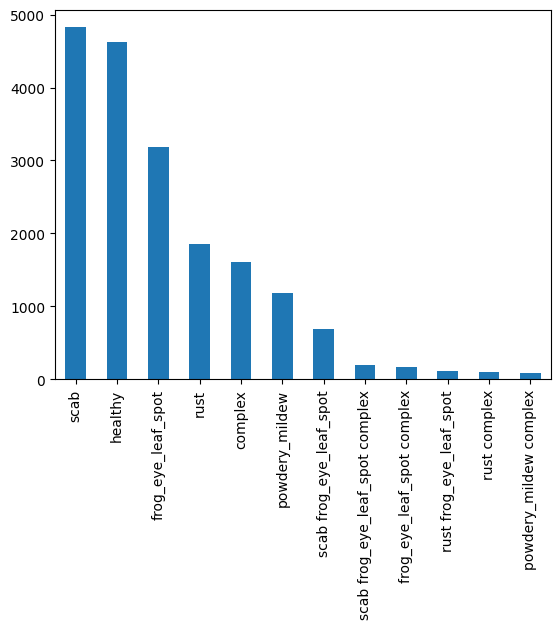

In [46]:
train = pd.read_csv(your_path + '/plant-pathology-2021-fgvc8/train.csv')
print(len(train))
print(train.columns)
# print(train['labels'].value_counts())
print(train['labels'].value_counts().plot.bar())

# Wait
Notice something. Unlike the previous year's competition [Plant Pathology 2020 - FGVC7](https://www.kaggle.com/c/plant-pathology-2020-fgvc7) one image can belong to more than one disease. Notice how in case of multiple diseases the diseases are seperated by an space. So there are not 12 labels, its actually just 6 labels.
5 dieseases: 

1. rust
2. scab 
3. complex 
4. frog eye leaf spot
5. powdery mildew 

and another label is 

6. healthy (healthy leaves) 

Now the most important thing is, as one image can have multiple diseases, that means this problem is **Multi label classification** problem. Many get confused betweeen multilabel and multiclass classification. if you are new to multilabel classification I would suggest going over this [An introduction to MultiLabel classification](https://www.geeksforgeeks.org/an-introduction-to-multilabel-classification/) . 

So now we gotta process the labels. And then lets find out the actual frequencies of the labels. 


In [47]:
train['labels'] = train['labels'].apply(lambda string: string.split(' '))
train

,image,labels
0,800113bb65efe69e.jpg,[healthy]
1,8002cb321f8bfcdf.jpg,"[scab, frog_eye_leaf_spot, complex]"
2,80070f7fb5e2ccaa.jpg,[scab]
3,80077517781fb94f.jpg,[scab]
4,800cbf0ff87721f8.jpg,[complex]
...,...,...
18627,fffb900a92289a33.jpg,[healthy]
18628,fffc488fa4c0e80c.jpg,[scab]
18629,fffc94e092a59086.jpg,[rust]
18630,fffe105cf6808292.jpg,"[scab, frog_eye_leaf_spot]"


First I convert the labels representation into **one hot encoded format** using MultilabelBinarizer from sklearn. Now we can see and plot the frequencies of each label. 

Index(['complex', 'frog_eye_leaf_spot', 'healthy', 'powdery_mildew', 'rust',
       'scab'],
      dtype='object')
complex               2151
frog_eye_leaf_spot    4352
healthy               4624
powdery_mildew        1271
rust                  2077
scab                  5712
dtype: int64
['complex', 'frog_eye_leaf_spot', 'healthy', 'powdery_mildew', 'rust', 'scab']


<Axes: >

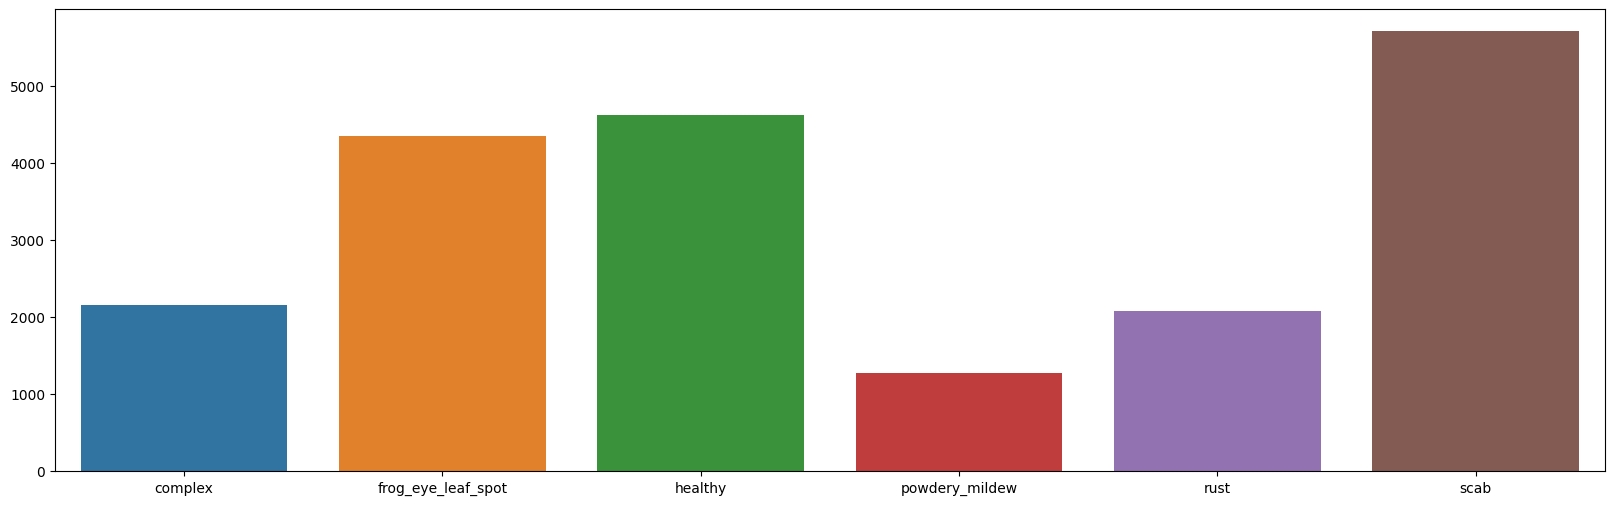

In [48]:
s = list(train['labels'])
mlb = MultiLabelBinarizer()
trainx = pd.DataFrame(mlb.fit_transform(s), columns=mlb.classes_, index=train.index)
print(trainx.columns)
print(trainx.sum())

labels = list(trainx.sum().keys())
print(labels)
label_counts = trainx.sum().values.tolist()

fig, ax = plt.subplots(1,1, figsize=(20,6))

sns.barplot(x= labels, y= label_counts, ax=ax)

# Let's view some of the images

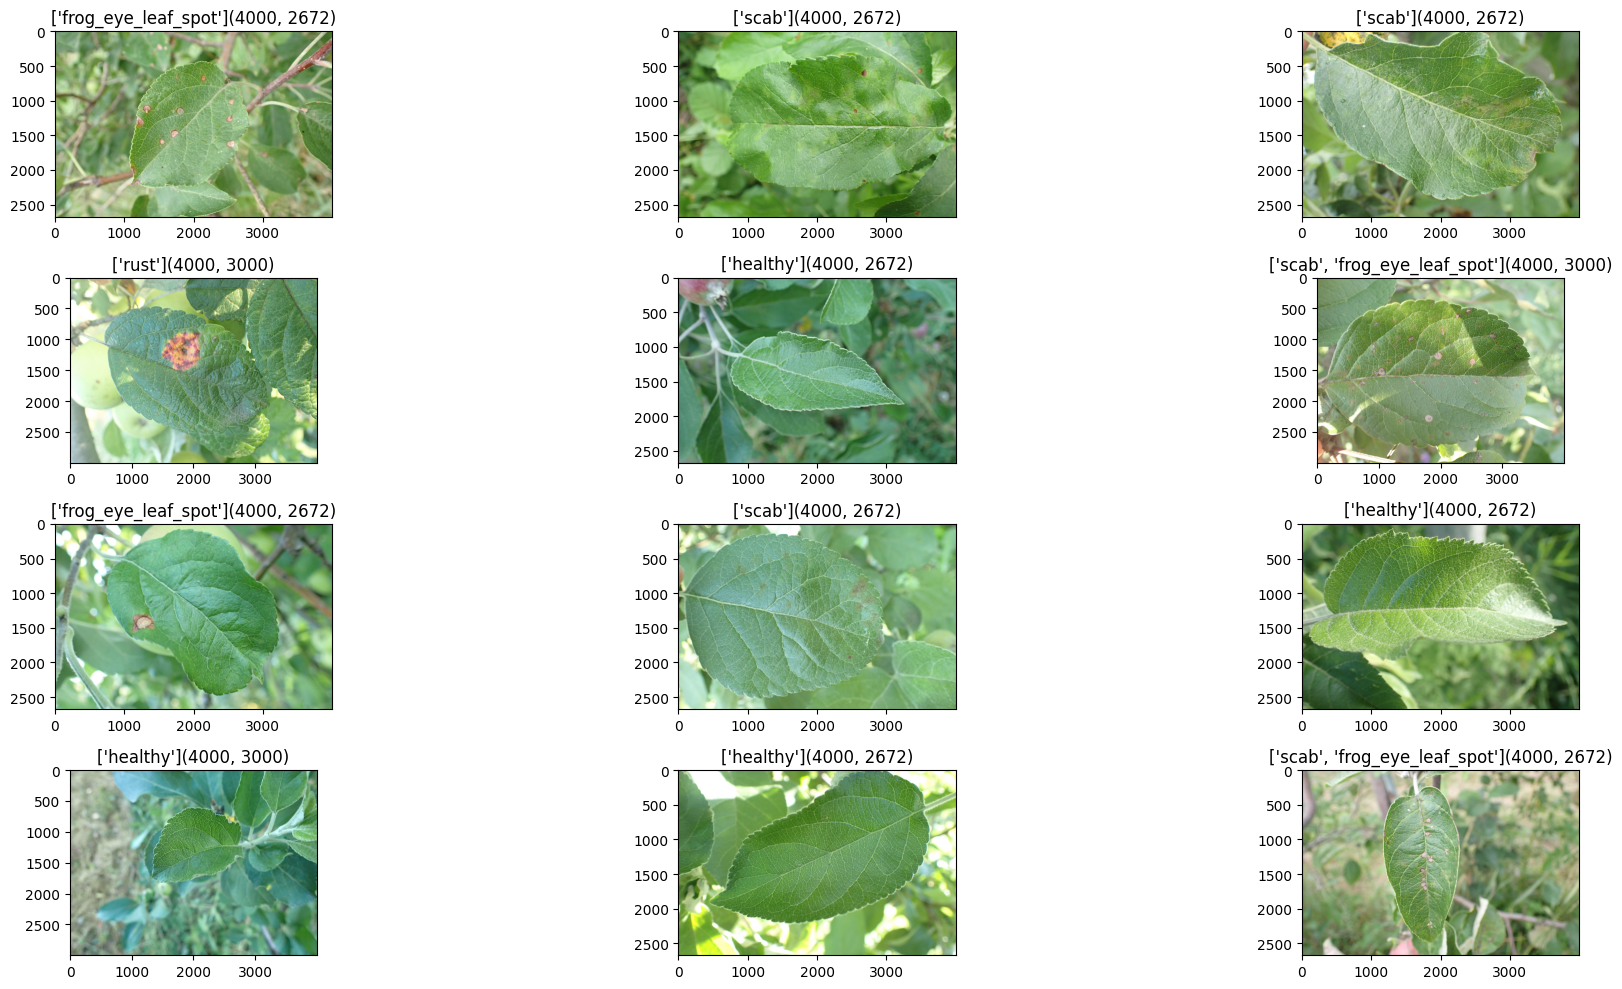

In [49]:
fig1 = plt.figure(figsize=(26,10))

for i in range(1, 13):
    
    rand =  random.randrange(1, 18000)
    sample = os.path.join(your_path + '/plant-pathology-2021-fgvc8/train_images/', train['image'][rand])
    
    img = PIL.Image.open(sample)
    
    ax = fig1.add_subplot(4,3,i)
    ax.imshow(img)
    
    title = f"{train['labels'][rand]}{img.size}"
    plt.title(title)
    
    fig1.tight_layout()


# Imaze Size & Processing
from the titles we can see some random image sizes - (4000, 2672). Larger images are harder to process hence takes much longer to train the CNN. Downsampling all these 18632 images is also a time consuming task. This is I am going to use the resized imaged for this dataset [resized-plant2021](https://www.kaggle.com/ankursingh12/resized-plant2021) by Ankur Singh. He has already downsampled the images into size of 256, 384, 512 & 640px.

There are 18632 images in the training set. Even after using the downsampled images we cant fit all of the images into memory at once. So I have used the flow_from_dataframe method from keras. This method reads images in batch size from the storage without loading all the images at once and saving us from **GPU Out of Memory (OOM)** issue. 

In [50]:
%%time
datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1/255.0,
                                                        preprocessing_function=None,
                                                        data_format=None,
                                                    )

train_data = datagen.flow_from_dataframe(
    train,
    directory='../input/resized-plant2021/img_sz_512',
    x_col="image",
    y_col= 'labels',
    color_mode="rgb",
    target_size = (256,256),
    class_mode="categorical",
    batch_size=32,
    shuffle=False,
    seed=40,
)

Found 0 validated image filenames belonging to 0 classes.
CPU times: user 56.2 ms, sys: 4.02 ms, total: 60.2 ms
Wall time: 70.2 ms


/home/vh/.local/lib/python3.11/site-packages/keras/preprocessing/image.py:1137: UserWarning: Found 18632 invalid image filename(s) in x_col="image". These filename(s) will be ignored.
  warnings.warn(


# Transfer Learning
Transfer learning is the process of using frozen weights from a large pre-trained model for a downstream task which is in our case classifying leaf diseases. As we can't use internet in this notebook, I will use the dataset of keras's pretrained models containing the weights of 'imagenet'. The output/top layer of a pretrained layer is a dense layer containing number of nodes = number of output classes. All the models here are pre-trained on 'imagenet' hence they have a output/top layer of 1000 nodes. We will have to replace the output/top layer with our own dense layer with 6 nodes (for 6 classes). 

I am going to be using **Inception ResNet v2**.


In [51]:
seed = 1200
tf.random.set_seed(seed)

weights_path = your_path + '/keras-pretrained-model/inception_resnet_v2_weights_tf_dim_ordering_tf_kernels_notop.h5'

model = keras.applications.InceptionResNetV2(weights=weights_path, include_top=False, input_shape=(256, 256, 3))

print(model.input)
print(model.output)

KerasTensor(type_spec=TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='input_6'), name='input_6', description="created by layer 'input_6'")
KerasTensor(type_spec=TensorSpec(shape=(None, 6, 6, 1536), dtype=tf.float32, name=None), name='conv_7b_ac/Relu:0', description="created by layer 'conv_7b_ac'")


# Activation, Losses & Metrices

As this is a multilabel classification problem, we can't use softmax here, hence the sigmoid activation.

Binary crossentropy is used instead of categorical crossentropy. We use categorical cross-entropy in multi-class problems, but for multi-label problems, we use binary cross-entropy. Think of it this way, an image may have multiple labels, and we need the probabilities that each of these labels corresponds to the given image - this can be considered as n independent binary classifiers for the n labels.

For evaluation I have used F1 accuracy metrics instead of binary accuracy. F1 and its variants are better for evaluation when it comes to multiclass and multilabel problems. if you want to know F1 score works for Multilabel classification go through this https://medium.com/synthesio-engineering/precision-accuracy-and-f1-score-for-multi-label-classification-34ac6bdfb404https://medium.com/synthesio-engineering/precision-accuracy-and-f1-score-for-multi-label-classification-34ac6bdfb404. 

In [52]:
new_model = tf.keras.Sequential([
    model,
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dense(6, 
        kernel_initializer=keras.initializers.RandomUniform(seed=seed),
        bias_initializer=keras.initializers.Zeros(), name='dense_top', activation='sigmoid')
])

# Freezing the weights
for layer in new_model.layers[:-1]:
    layer.trainable=False
    
new_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Functi  (None, 6, 6, 1536)       54336736  
 onal)                                                           
                                                                 
 global_average_pooling2d (G  (None, 1536)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_top (Dense)           (None, 6)                 9222      
                                                                 
Total params: 54,345,958
Trainable params: 9,222
Non-trainable params: 54,336,736
_________________________________________________________________


In [53]:
f1 = tfa.metrics.F1Score(num_classes=6, average='macro')

callbacks = keras.callbacks.EarlyStopping(monitor=f1, patience=3, mode='max', restore_best_weights=True)


new_model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=keras.optimizers.Adam(lr=1e-4), 
              metrics= [f1])

new_model.fit(train_data, epochs=40, callbacks=callbacks)

ValueError: ignored

# Submission

For submission I will resize the test images and then predict the labels for them.

In [ ]:
test = pd.read_csv(your_path + '/plant-pathology-2021-fgvc8/sample_submission.csv')
for img_name in tqdm(test['image']):
    path = your_path + '/plant-pathology-2021-fgvc8/test_images/'+str(img_name)
    with PIL.Image.open(path) as img:
        img = img.resize((256,256))
        img.save(f'./{img_name}')

In [ ]:
test_data = datagen.flow_from_dataframe(
    test,
    directory = './',
    x_col="image",
    y_col= None,
    color_mode="rgb",
    target_size = (256,256),
    classes=None,
    class_mode=None,
    batch_size=32,
    shuffle=False,
    seed=40,
)

preds = new_model.predict(test_data)
print(preds)
preds = preds.tolist()

indices = []
for pred in preds:
    temp = []
    for category in pred:
        if category>=0.3:
            temp.append(pred.index(category))
    if temp!=[]:
        indices.append(temp)
    else:
        temp.append(np.argmax(pred))
        indices.append(temp)
    
print(indices)

In [ ]:
labels = (train_data.class_indices)
labels = dict((v,k) for k,v in labels.items())
print(labels)

testlabels = []


for image in indices:
    temp = []
    for i in image:
        temp.append(str(labels[i]))
    testlabels.append(' '.join(temp))

print(testlabels)

Remove the resized images from output before submission. if there are any other files present except 'submission.csv' it will throw an error when submitting.

In [ ]:
delfiles = tf.io.gfile.glob('./*.jpg')

for file in delfiles:
    os.remove(file)

In [ ]:
sub = pd.read_csv('../input/plant-pathology-2021-fgvc8/sample_submission.csv')
sub['labels'] = testlabels
sub.to_csv('submission.csv', index=False)
sub
